# ODE & SDE 的代码实践

In [23]:
from abc import ABC, abstractmethod
from typing import Optional
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        pass
    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        pass

## ODE 和 SDE 的一阶欧拉法采样过程

ODE 和 SDE 相比，ODE 说的是：如果在 $X_0$ 从 $x_0$ 出发，那在时间 $t$ 的时刻，就会以 $u_t(X_t)$ 的速度移动；而 SDE 则是在 ODE 的基础上增加了一个强度为 $\sigma_t$ 的随机噪声。但对于 $u_t$ 复杂的情况，我们难以求出解析解，就只能用数值方法去逼近。

ODE 的一阶欧拉法采样的过程为

$$ \mathrm d X_t = u_t(X_t) \mathrm d t \Rightarrow X_{t+h} = X_t + h u_t(X_t)$$

同理，SDE 的一阶欧拉-雅玛法采样的过程为

$$ \mathrm d X_t = u_t(X_t) \mathrm d t + \sigma_t \mathrm d W_t \Rightarrow X_{t+h} = X_t + h u_t(X_t) + \sqrt{h}\sigma_t \epsilon_t\quad \epsilon_t\sim \mathcal N(0, I)$$

如下为代码实现

In [24]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        pass
    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        ts: 也即所有timesteps t。shape 为 [nts, ]
        x: 数据。shape 为 [Batch size, dim]
        """
        for t_idx in range(len(ts) - 1):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
        return x
    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        ts: 也即所有timesteps t。shape 为 [nts, ]
        x: 单步数据。shape 为 [Batch size, dim]
        xs: 所有步的数据，shape 为 [Batch size, nts, dim]
        """
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

In [25]:
class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        #! 这里本质上 Velocity field 给出的就是 drift 系数！
        #! 对应公式：X_{t+h} = X_t + u(X_t, t) * h
        return xt + self.ode.drift_coefficient(xt, t) * h
    
class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        #! 对应公式：X_{t+h} = X_t + u(X_t, t) * h + \sqrt{h} * sigma(X_t, t) * epsilon
        return xt + self.sde.drift_coefficient(xt, t) * h + self.sde.diffusion_coefficient(xt, t) * torch.sqrt(h) * torch.randn_like(xt)

如果在 SDE 里面的 Diffusion 系数设为 0，那就和 ODE 里只有 Drift 系数是等价的！

## 随机过程的实现理解

我们大概模拟一个布朗运动：布朗运动的随机微分方程是 drift 均值为0，而 diffusion 是一个带有系数的标准高斯分布。也就是
$ \mathcal N(0, \sigma^2 I)$，也就是我们可以视为：$$ \mathrm d X_t = 0 \mathrm d t + \sigma \mathrm d W_t $$

  0%|          | 0/499 [00:00<?, ?it/s]

100%|██████████| 499/499 [00:00<00:00, 8080.32it/s]


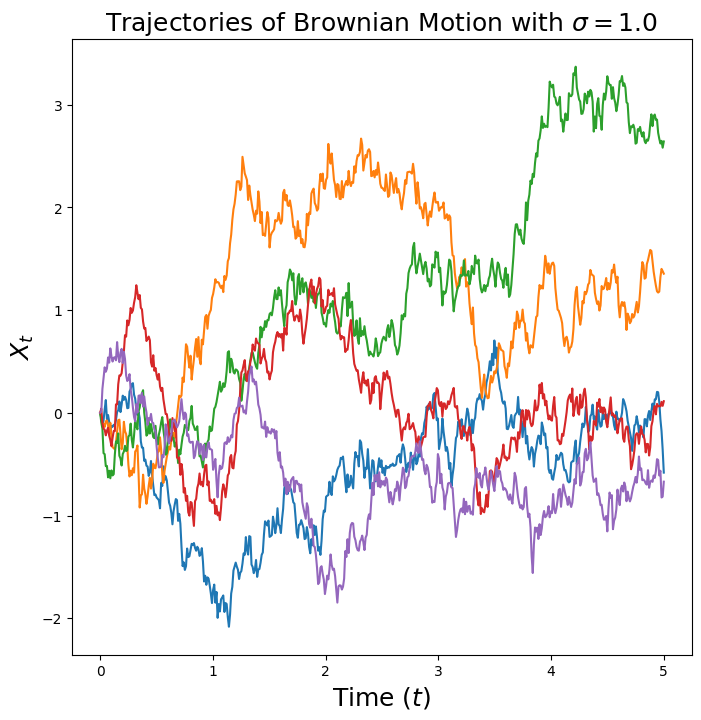

In [26]:
class BrownianMotion(SDE):
    def __init__(self, sigma: float):
        self.sigma = sigma
        
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return torch.zeros_like(xt)

    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.sigma * torch.ones_like(xt)

def plot_trajectories_1d(x0: torch.Tensor, simulator: Simulator, timesteps: torch.Tensor, ax: Optional[Axes] = None):
        """
        Graphs the trajectories of a one-dimensional SDE with given initial values (x0) and simulation timesteps (timesteps).
        Args:
            - x0: state at time t, shape (num_trajectories, 1)
            - simulator: Simulator object used to simulate
            - t: timesteps to simulate along, shape (num_timesteps,)
            - ax: pyplot Axes object to plot on
        """
        if ax is None:
            ax = plt.gca()
        trajectories = simulator.simulate_with_trajectory(x0, timesteps) # (num_trajectories, num_timesteps, ...)
        for trajectory_idx in range(trajectories.shape[0]):
            trajectory = trajectories[trajectory_idx, :, 0] # (num_timesteps,)
            ax.plot(ts.cpu(), trajectory.cpu())

sigma = 1.0
brownian_motion = BrownianMotion(sigma)
simulator = EulerMaruyamaSimulator(sde=brownian_motion)
x0 = torch.zeros(5,1).to(device) # Initial values - let's start at zero
ts = torch.linspace(0.0,5.0,500).to(device) # simulation timesteps

plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.set_title(r'Trajectories of Brownian Motion with $\sigma=$' + str(sigma), fontsize=18)
ax.set_xlabel(r'Time ($t$)', fontsize=18)
ax.set_ylabel(r'$X_t$', fontsize=18)
plot_trajectories_1d(x0, simulator, ts, ax)
plt.show()

我们再实现一个过程：Ornstein-Uhlenbeck Process。其过程里 Drift 系数 $u(t, X_t) = -\theta X_t$，Diffusion 系数 $\sigma_t = \sigma$，SDE 是

$$ \mathrm d X_t = - \theta X_t \mathrm d t+ \sigma \mathrm d W_t$$

100%|██████████| 999/999 [00:00<00:00, 9088.33it/s]


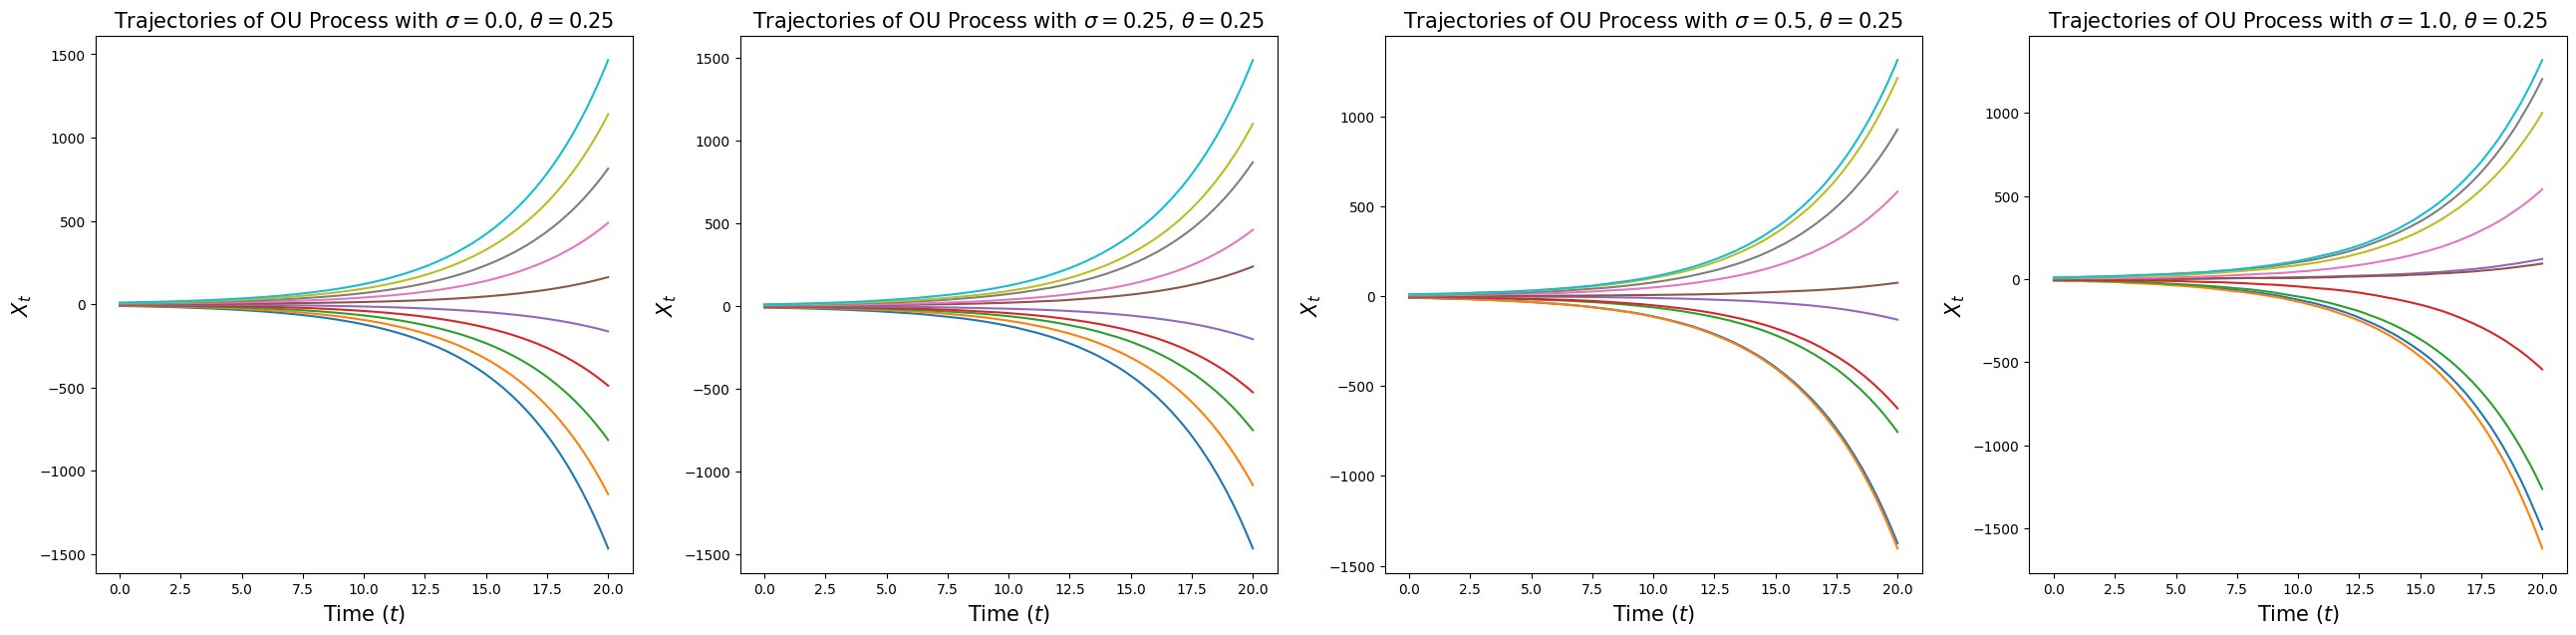

In [27]:
class OUProcess(SDE):
    def __init__(self, theta: float, sigma: float):
        self.theta = theta
        self.sigma = sigma
        
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.theta * xt
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.sigma * torch.ones_like(xt)
    
thetas_and_sigmas = [
    (0.25, 0.0),
    (0.25, 0.25),
    (0.25, 0.5),
    (0.25, 1.0),
]
simulation_time = 20.0

num_plots = len(thetas_and_sigmas)
fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 7))

for idx, (theta, sigma) in enumerate(thetas_and_sigmas):
    ou_process = OUProcess(theta, sigma)
    simulator = EulerMaruyamaSimulator(sde=ou_process)
    x0 = torch.linspace(-10.0,10.0,10).view(-1,1).to(device) # Initial values - let's start at zero
    ts = torch.linspace(0.0,simulation_time,1000).to(device) # simulation timesteps

    ax = axes[idx]
    ax.set_title(f'Trajectories of OU Process with $\\sigma = ${sigma}, $\\theta = ${theta}', fontsize=15)
    ax.set_xlabel(r'Time ($t$)', fontsize=15)
    ax.set_ylabel(r'$X_t$', fontsize=15)
    plot_trajectories_1d(x0, simulator, ts, ax)
plt.show()

注意 ratio $D = \dfrac{\sigma^2}{\theta}$ 的变化，看看收敛性？

100%|██████████| 999/999 [00:00<00:00, 28722.40it/s]


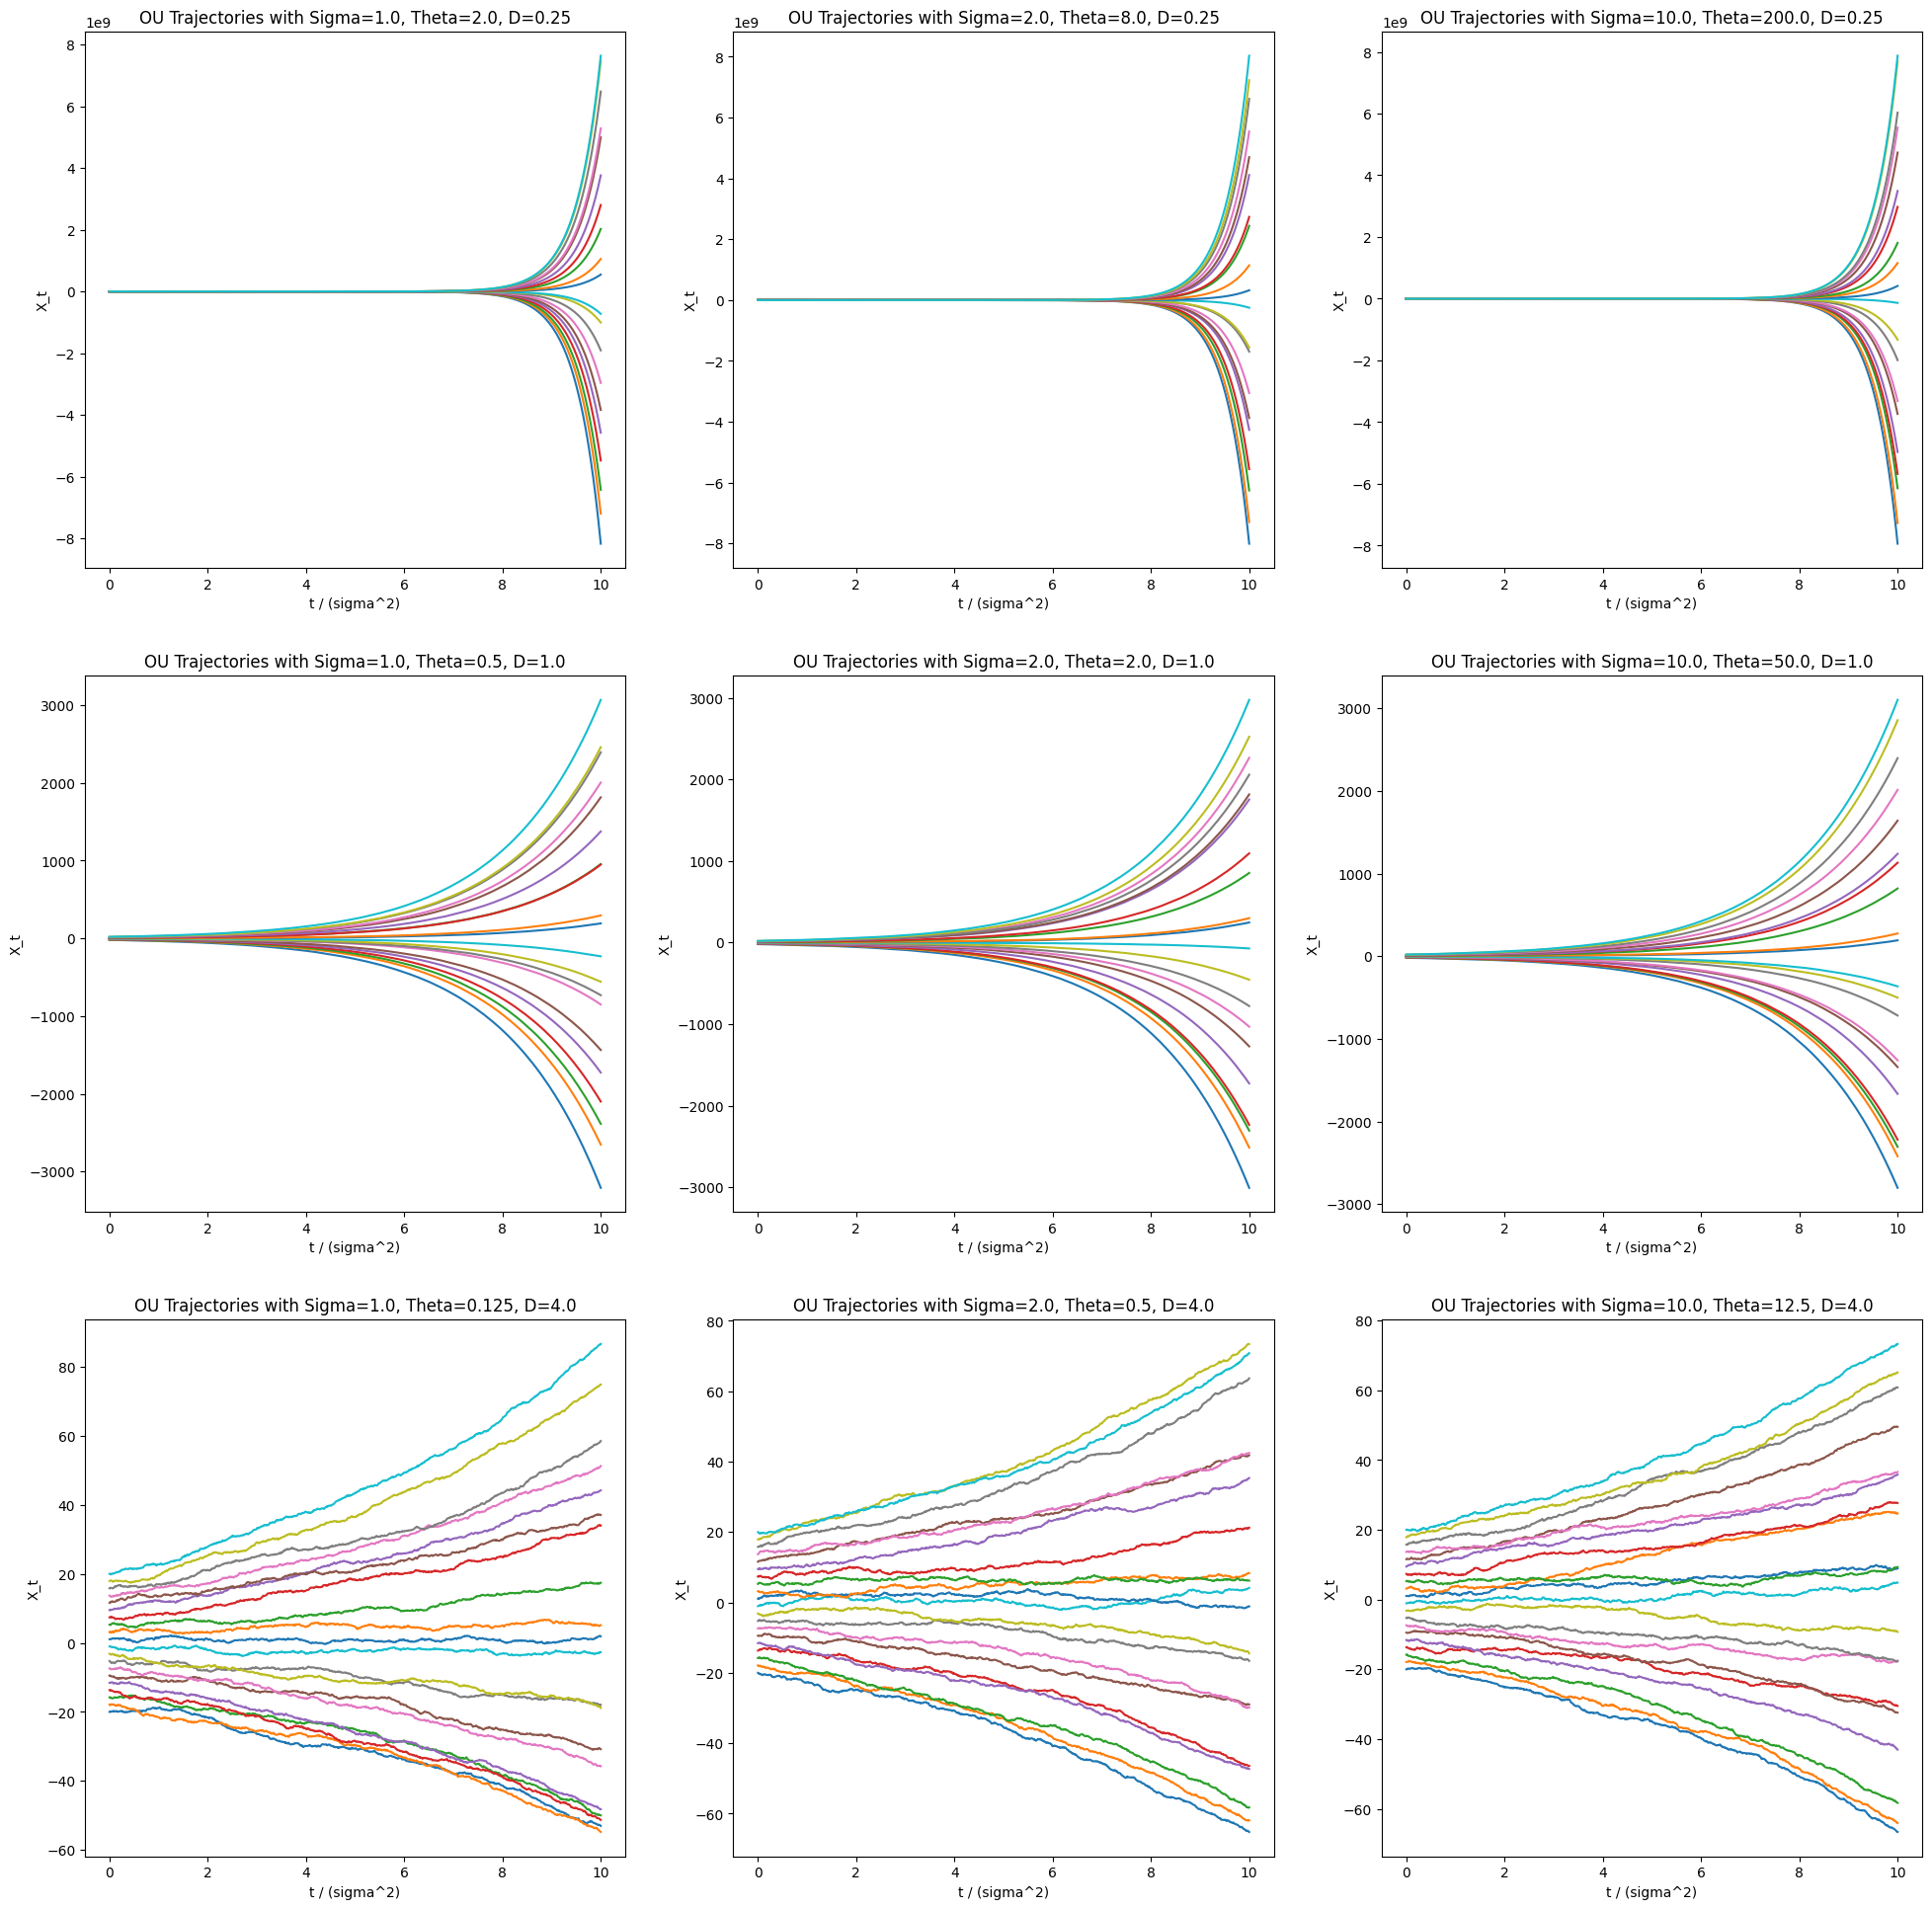

In [28]:
def plot_scaled_trajectories_1d(x0: torch.Tensor, simulator: Simulator, timesteps: torch.Tensor, time_scale: float, label: str, ax: Optional[Axes] = None):
        """
        Graphs the trajectories of a one-dimensional SDE with given initial values (x0) and simulation timesteps (timesteps).
        Args:
            - x0: state at time t, shape (num_trajectories, 1)
            - simulator: Simulator object used to simulate
            - t: timesteps to simulate along, shape (num_timesteps,)
            - time_scale: scalar by which to scale time
            - label: self-explanatory
            - ax: pyplot Axes object to plot on
        """
        if ax is None:
            print('moo')
            ax = plt.gca()
        trajectories = simulator.simulate_with_trajectory(x0, timesteps) # (num_trajectories, num_timesteps, ...)
        for trajectory_idx in range(trajectories.shape[0]):
            trajectory = trajectories[trajectory_idx, :, 0] # (num_timesteps,)
            ax.plot(ts.cpu() * time_scale, trajectory.cpu(), label=label)
# Let's try rescaling with time
sigmas = [1.0, 2.0, 10.0]
ds = [0.25, 1.0, 4.0] # sigma**2 / 2t
simulation_time = 10.0

fig, axes = plt.subplots(len(ds), len(sigmas), figsize=(8 * len(sigmas), 8 * len(ds)))
axes = axes.reshape((len(ds), len(sigmas)))
for d_idx, d in enumerate(ds):
    for s_idx, sigma in enumerate(sigmas):
        theta = sigma**2 / 2 / d
        ou_process = OUProcess(theta, sigma)
        simulator = EulerMaruyamaSimulator(sde=ou_process)
        x0 = torch.linspace(-20.0,20.0,20).view(-1,1).to(device)
        time_scale = sigma**2
        ts = torch.linspace(0.0,simulation_time / time_scale,1000).to(device) # simulation timesteps
        ax = axes[d_idx, s_idx]
        plot_scaled_trajectories_1d(x0=x0, simulator=simulator, timesteps=ts, time_scale=time_scale, label=f'Sigma = {sigma}', ax=ax)
        ax.set_title(f'OU Trajectories with Sigma={sigma}, Theta={theta}, D={d}')
        ax.set_xlabel(f't / (sigma^2)')
        ax.set_ylabel('X_t')
plt.show()

## Langevin 动力学

常看 Score Matching 的肯定都听说过 Langevin Dynamics。下面我们来看一下 Langevin Dynamics 是如何将一个分布变换到另一个分布的。

下面定义一个 GMM：

In [29]:
class Density(ABC):
    @abstractmethod
    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        pass

    def score(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1)  # (batch_size, 1, ...)
        score = vmap(jacrev(self.log_density))(x)  # (batch_size, 1, 1, 1, ...)
        #! 核心在这里！通过对数密度函数，jacrev 计算出了 Jacobi 矩阵，也就是梯度导数！
        return score.squeeze((1, 2, 3))  # (batch_size, ...)
    
class Sampleable(ABC):
    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        pass

In [30]:
# Several plotting utility functions
def hist2d_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.hist2d(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def scatter_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.scatter(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def imshow_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale, scale, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.imshow(density.cpu(), extent=[-scale, scale, -scale, scale], origin='lower', **kwargs)

def contour_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale, scale, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.contour(density.cpu(), extent=[-scale, scale, -scale, scale], origin='lower', **kwargs)

In [31]:
class Gaussian(torch.nn.Module, Sampleable, Density):
    def __init__(self, mean, cov):
        """
        mean: shape (2,)
        cov: shape (2,2)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))

    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)
    

class Gaussian(torch.nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian. Is a Density and a Sampleable. Wrapper around torch.distributions.MultivariateNormal
    """
    def __init__(self, mean, cov):
        """
        mean: shape (2,)
        cov: shape (2,2)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))

    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)

class GaussianMixture(torch.nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian mixture model, and is a Density and a Sampleable. Wrapper around torch.distributions.MixtureSameFamily.
    """
    def __init__(
        self,
        means: torch.Tensor,  # nmodes x data_dim
        covs: torch.Tensor,  # nmodes x data_dim x data_dim
        weights: torch.Tensor,  # nmodes
    ):
        """
        means: shape (nmodes, 2)
        covs: shape (nmodes, 2, 2)
        weights: shape (nmodes, 1)
        """
        super().__init__()
        self.nmodes = means.shape[0]
        self.register_buffer("means", means)
        self.register_buffer("covs", covs)
        self.register_buffer("weights", weights)

    @property
    def dim(self) -> int:
        return self.means.shape[1]

    @property
    def distribution(self):
        return D.MixtureSameFamily(
                mixture_distribution=D.Categorical(probs=self.weights, validate_args=False),
                component_distribution=D.MultivariateNormal(
                    loc=self.means,
                    covariance_matrix=self.covs,
                    validate_args=False,
                ),
                validate_args=False,
            )

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, num_samples: int) -> torch.Tensor:
        return self.distribution.sample(torch.Size((num_samples,)))

    @classmethod
    def random_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, seed = 0.0
    ) -> "GaussianMixture":
        torch.manual_seed(seed)
        means = (torch.rand(nmodes, 2) - 0.5) * scale
        covs = torch.diag_embed(torch.ones(nmodes, 2)) * std ** 2
        weights = torch.ones(nmodes)
        return cls(means, covs, weights)

    @classmethod
    def symmetric_2D(
        cls, nmodes: int, std: float, scale: float = 10.0,
    ) -> "GaussianMixture":
        angles = torch.linspace(0, 2 * np.pi, nmodes + 1)[:nmodes]
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * scale
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        weights = torch.ones(nmodes) / nmodes
        return cls(means, covs, weights)

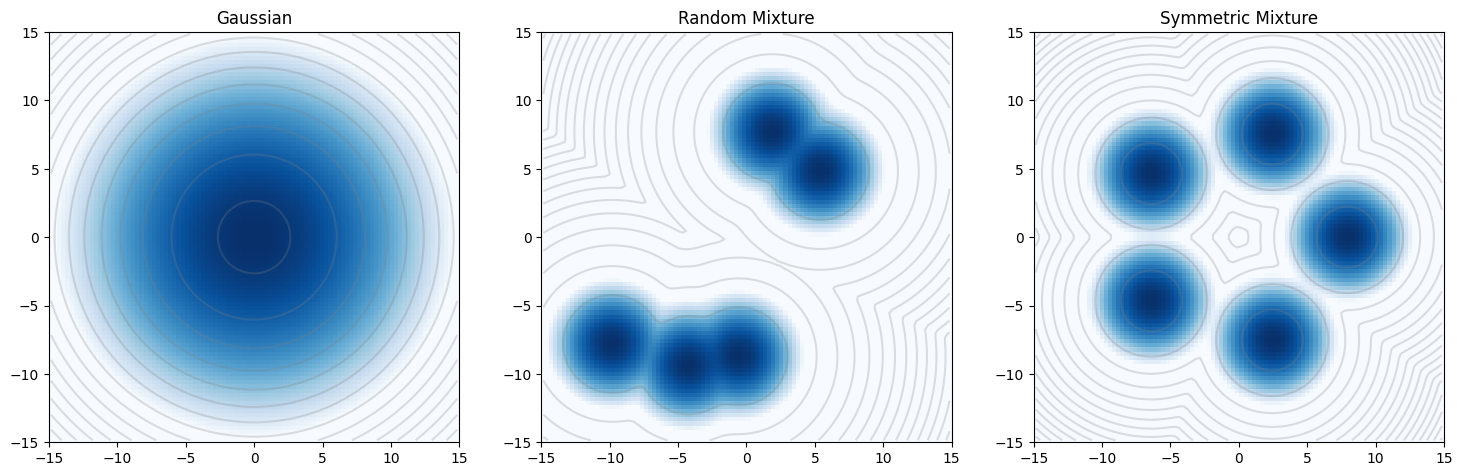

In [32]:
densities = {
    "Gaussian": Gaussian(mean=torch.zeros(2), cov=10 * torch.eye(2)).to(device),
    "Random Mixture": GaussianMixture.random_2D(nmodes=5, std=1.0, scale=20.0, seed=3.0).to(device),
    "Symmetric Mixture": GaussianMixture.symmetric_2D(nmodes=5, std=1.0, scale=8.0).to(device),
}

fig, axes = plt.subplots(1,3, figsize=(18, 6))
bins = 100
scale = 15
for idx, (name, density) in enumerate(densities.items()):
    ax = axes[idx]
    ax.set_title(name)
    imshow_density(density, bins, scale, ax, vmin=-15, cmap=plt.get_cmap('Blues'))
    contour_density(density, bins, scale, ax, colors='grey', linestyles='solid', alpha=0.25, levels=20)
plt.show()

Langevin Dynamics 的 SDE 为：
$$ \mathrm d X_t= \dfrac{1}{2}\sigma^2 \nabla \log p(X_t)\mathrm d t + \sigma \mathrm d W_t $$

其可以实现如下：


In [33]:
class LangevinSDE(SDE):
    def __init__(self, sigma: float, density: Density):
        self.sigma = sigma
        self.density = density

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return 0.5 * (self.sigma ** 2) * self.density.score(xt)
    
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.sigma * torch.ones_like(xt)

我们看一下结果吧！

100%|██████████| 999/999 [00:04<00:00, 234.43it/s]


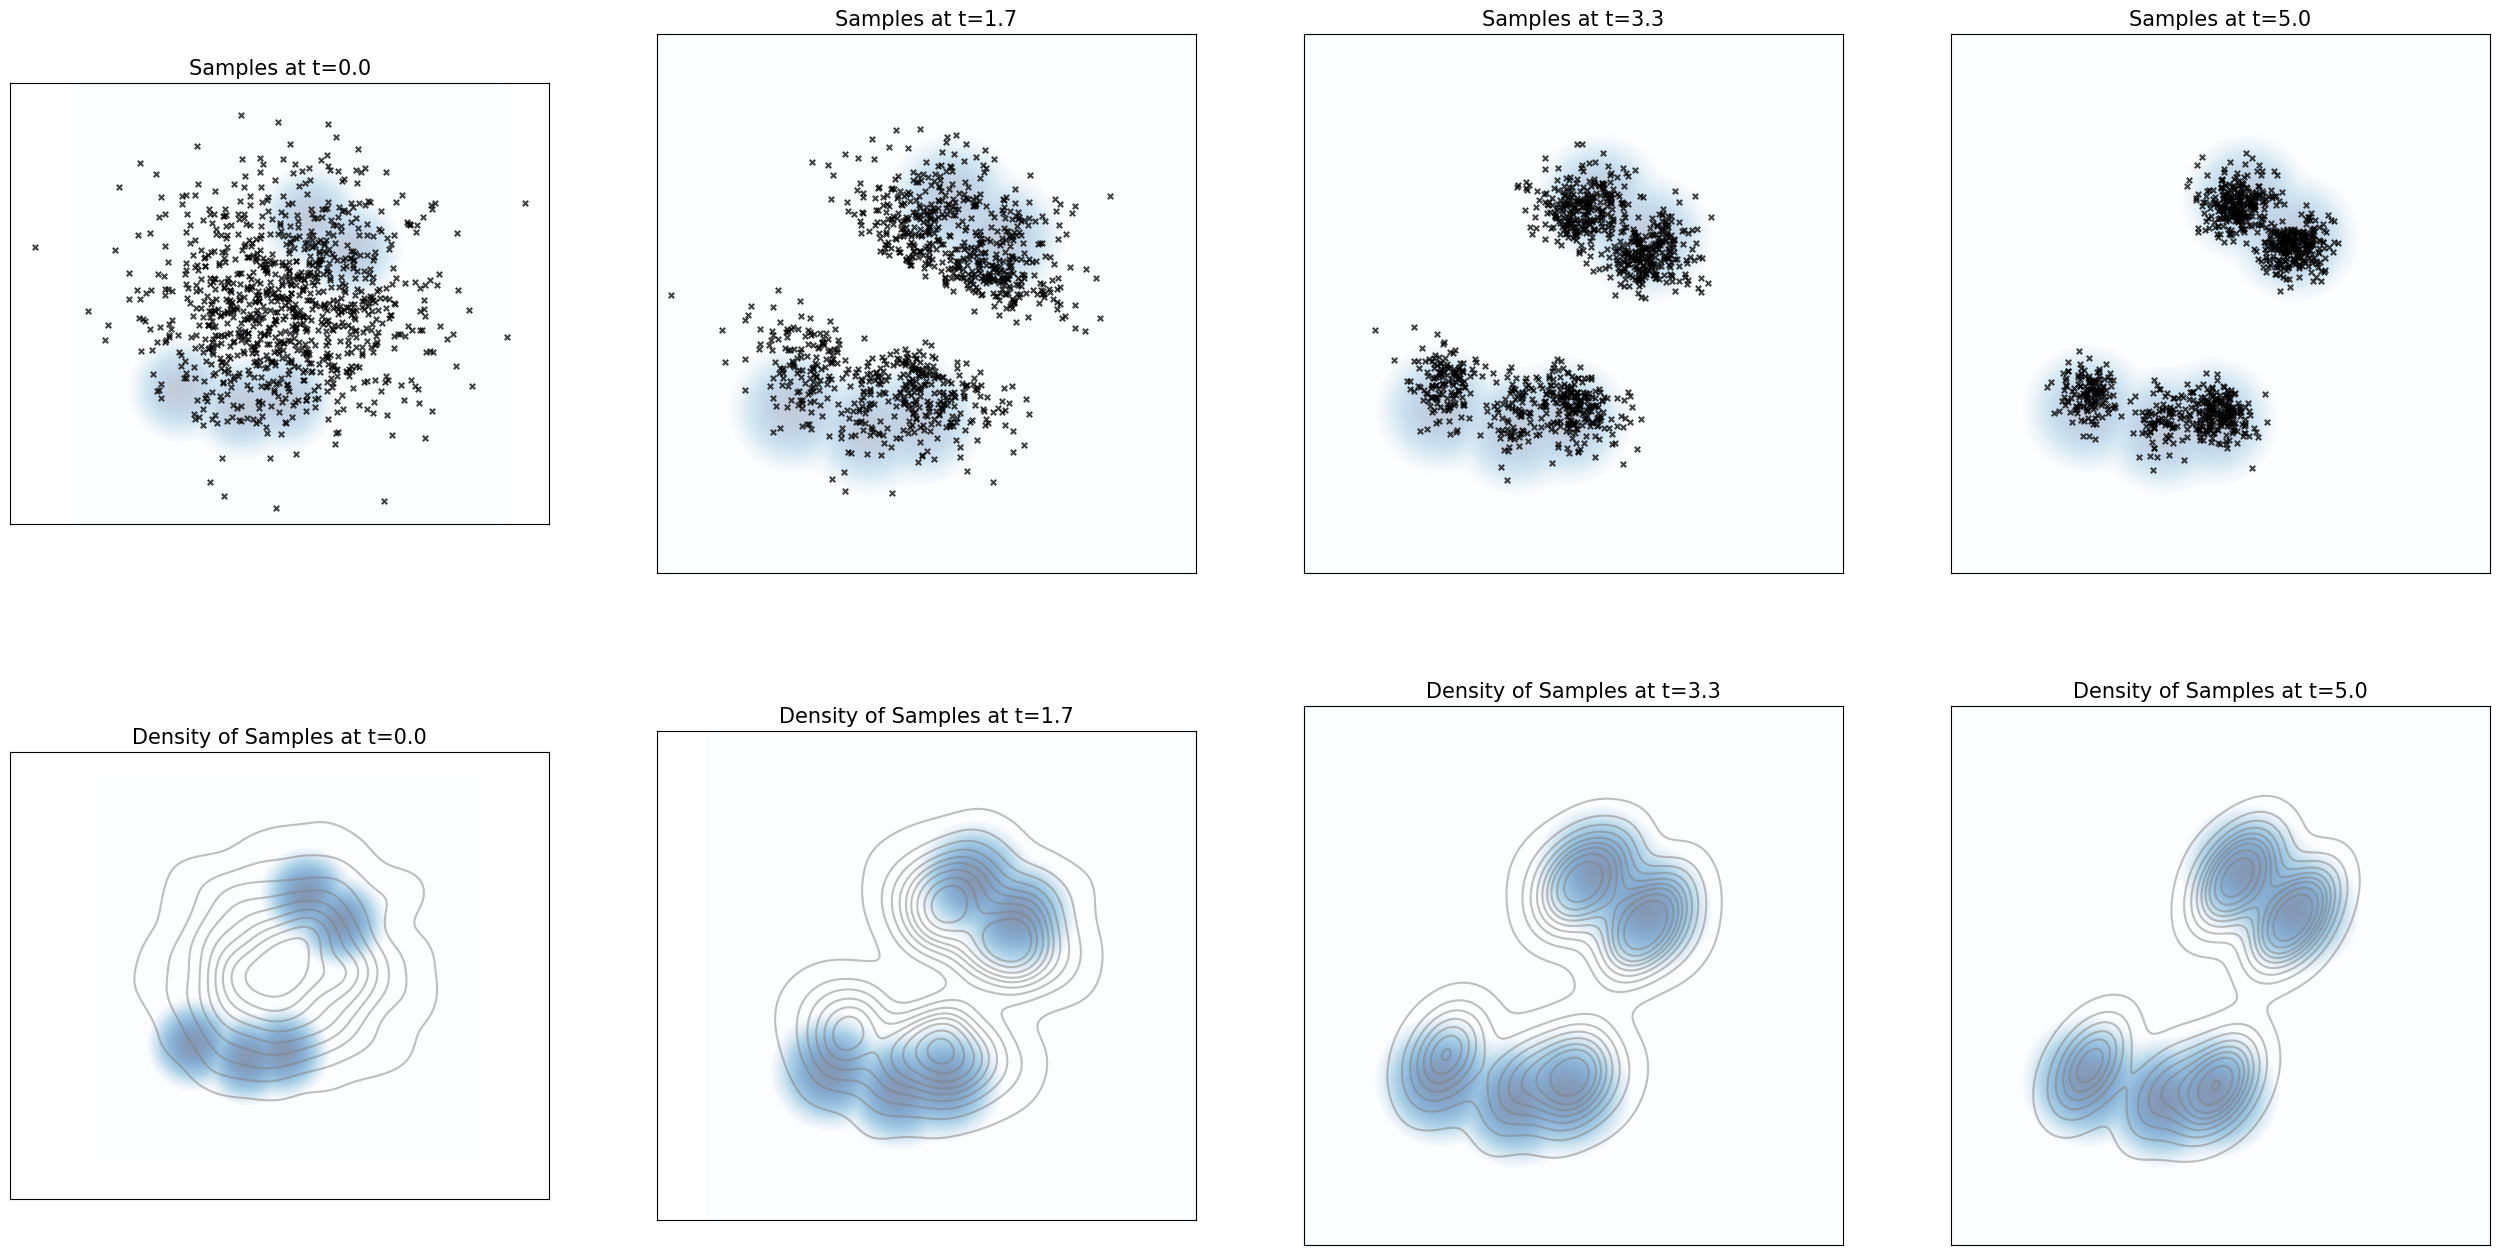

In [ ]:
def every_nth_index(num_timesteps: int, n: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if n == 1:
        return torch.arange(num_timesteps)
    return torch.cat([torch.arange(0, num_timesteps - 1, n), torch.tensor([num_timesteps - 1]),])

def graph_dynamics(
    num_samples: int,
    source_distribution: Sampleable,
    simulator: Simulator, 
    density: Density,
    timesteps: torch.Tensor, 
    plot_every: int,
    bins: int,
    scale: float
):
    """
    Plot the evolution of samples from source under the simulation scheme given by simulator (itself a discretization of an ODE or SDE).
    Args:
        - num_samples: the number of samples to simulate
        - source_distribution: distribution from which we draw initial samples at t=0
        - simulator: the discertized simulation scheme used to simulate the dynamics
        - density: the target density
        - timesteps: the timesteps used by the simulator
        - plot_every: number of timesteps between consecutive plots
        - bins: number of bins for imshow
        - scale: scale for imshow
    """
    # Simulate
    x0 = source_distribution.sample(num_samples)
    xts = simulator.simulate_with_trajectory(x0, timesteps)
    indices_to_plot = every_nth_index(len(timesteps), plot_every)
    plot_timesteps = timesteps[indices_to_plot]
    plot_xts = xts[:,indices_to_plot]

    # Graph
    fig, axes = plt.subplots(2, len(plot_timesteps), figsize=(8*len(plot_timesteps), 16))
    axes = axes.reshape((2,len(plot_timesteps)))
    for t_idx in range(len(plot_timesteps)):
        t = plot_timesteps[t_idx].item()
        xt = plot_xts[:,t_idx]
        # Scatter axes
        scatter_ax = axes[0, t_idx]
        imshow_density(density, bins, scale, scatter_ax, vmin=-15, alpha=0.25, cmap=plt.get_cmap('Blues'))
        scatter_ax.scatter(xt[:,0].cpu(), xt[:,1].cpu(), marker='x', color='black', alpha=0.75, s=15)
        scatter_ax.set_title(f'Samples at t={t:.1f}', fontsize=15)
        scatter_ax.set_xticks([])
        scatter_ax.set_yticks([])

        # Kdeplot axes
        kdeplot_ax = axes[1, t_idx]
        imshow_density(density, bins, scale, kdeplot_ax, vmin=-15, alpha=0.5, cmap=plt.get_cmap('Blues'))
        sns.kdeplot(x=xt[:,0].cpu(), y=xt[:,1].cpu(), alpha=0.5, ax=kdeplot_ax,color='grey')
        kdeplot_ax.set_title(f'Density of Samples at t={t:.1f}', fontsize=15)
        kdeplot_ax.set_xticks([])
        kdeplot_ax.set_yticks([])
        kdeplot_ax.set_xlabel("")
        kdeplot_ax.set_ylabel("")

    plt.show()

# Construct the simulator
target = GaussianMixture.random_2D(nmodes=5, std=0.75, scale=15.0, seed=3.0).to(device)
sde = LangevinSDE(sigma = 0.6, density = target)
simulator = EulerMaruyamaSimulator(sde)

# Graph the results!
graph_dynamics(
    num_samples = 1000,
    source_distribution = Gaussian(mean=torch.zeros(2), cov=20 * torch.eye(2)).to(device),
    simulator=simulator,
    density=target,
    timesteps=torch.linspace(0,5.0,1000).to(device),
    plot_every=334,
    bins=200,
    scale=15
)   

Ornstein-Uhlenbeck 随机过程用 Langevin Dynamics 是什么样子的呢？我们知道：Langevin Dynamics 的 SDE 为：
$$ \mathrm d X_t= \dfrac{1}{2}\sigma^2 \nabla \log p(X_t)\mathrm d t + \sigma \mathrm d W_t $$

而 Ornstein 随机过程的 SDE 为
$$ \mathrm d X_t= -\theta X_t \mathrm d t + \sigma \mathrm d W_t $$

当我们取 $p(x) = \mathcal N(0, \frac{\sigma^2}{2\theta})$，可以得到

$$ p(x) = \dfrac{1}{\sqrt{2\pi}\sigma}\exp\left(-\dfrac{x^2\theta}{\sigma}\right) \Rightarrow \log p(x) = -\dfrac{x^2\theta}{\sigma} + C\Rightarrow \nabla \log p(x) = -\dfrac{2\theta}{\sigma^2}x $$

我们将其带入到 Langevin Dynamics 方程，是不是发现 $p(x)$ 是这个正泰分布的时候，对应的 Langevin Dynamics 就是对应的 Ornstein-Uhlenbeck 随机过程的 SDE！